In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, completeness_score, homogeneity_score
from sklearn.metrics import pairwise_distances

from wordcloud import WordCloud

import os

In [2]:
df = pd.read_csv('../data/processed/refined_df.csv')
df.head()

,address,career_objective,skills,educational_institution_name,degree_names,passing_years,educational_results,result_types,major_field_of_studies,professional_company_names,...,responsibilities.1,skills_required,matched_score,experience_years_required,Skill_Overlap_Count,Skill_Jaccard_Score,Resume_Years_Exp,Experience_Mismatch,highest_education_level,degree_type
0,NaN,Big data analytics working and database wareho...,"['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapr...",['The Amity School of Engineering & Technology...,['B.Tech'],['2019'],['N/A'],[None],['Electronics'],['Coca-COla'],...,Technical Support\nTroubleshooting\nCollaborat...,NaN,0.850000,1,0.0,0.0,6,5,Bachelors,STEM
1,NaN,Fresher looking to join as a data analyst and ...,"['Data Analysis', 'Data Analytics', 'Business ...","['Delhi University - Hansraj College', 'Delhi ...","['B.Sc (Maths)', 'M.Sc (Science) (Statistics)']","['2015', '2018']","['N/A', 'N/A']","['N/A', 'N/A']","['Mathematics', 'Statistics']",['BIB Consultancy'],...,Machine Learning Leadership\nCross-Functional ...,NaN,0.750000,5,0.0,0.0,6,1,Masters,STEM
2,NaN,NaN,"['Software Development', 'Machine Learning', '...","['Birla Institute of Technology (BIT), Ranchi']",['B.Tech'],['2018'],['N/A'],['N/A'],['Electronics/Telecommunication'],['Axis Bank Limited'],...,"Trade Marketing Executive\nBrand Visibility, S...",Brand Promotion\nCampaign Management\nField Su...,0.416667,3,0.0,0.0,7,4,Bachelors,STEM
3,NaN,To obtain a position in a fast-paced business ...,"['accounts payables', 'accounts receivables', ...","['Martinez Adult Education, Business Training ...",['Computer Applications Specialist Certificate...,['2008'],[None],[None],['Computer Applications'],"['Company Name ï¼ City , State', 'Company Name...",...,Apparel Sourcing\nQuality Garment Sourcing\nRe...,Fast typing skill\nIELTSInternet browsing & on...,0.760000,1,0.0,0.0,13,12,Other,STEM
4,NaN,Professional accountant with an outstanding wo...,"['Analytical reasoning', 'Compliance testing k...",['Kent State University'],['Bachelor of Business Administration'],[None],['3.84'],[None],['Accounting'],"['Company Name', 'Company Name', 'Company Name...",...,iOS Lifecycle\nRequirement Analysis\nNative Fr...,iOS\niOS App Developer\niOS Application Develo...,0.650000,4,0.0,0.0,17,13,Bachelors,Business


In [3]:
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(r'\ufeff', '', regex=True)
print("Column names cleaned.")

Column names cleaned.


## Clustering:

Now, we are trying clustering for the resumes. We are trying different combinations of cols, like skills, experience, etc. 

In [4]:
df['resume_text'] = "skills " + df['skills'].fillna('') + " position " + df['positions'].fillna('') + " " + 'experience ' + df['Resume_Years_Exp'].astype(str) + " highest educational level " + df['highest_education_level'].astype(str) + " degree " + df['degree_type'].astype(str)

In [5]:
df['resume_text'][0]

"skills ['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapreduce', 'Spark', 'Java', 'Machine Learning', 'Cloud', 'Hdfs', 'YARN', 'Core Java', 'Data Science', 'C++', 'Data Structures', 'DBMS', 'RDBMS', 'Informatica', 'Talend', 'Amazon Redshift', 'Microsoft Azure'] position ['Big Data Analyst'] experience 6 highest educational level Bachelors degree STEM"

### Vectorizing resume text:

In [6]:
tfidf = TfidfVectorizer(stop_words='english')

In [7]:
resume_tfidf = tfidf.fit_transform(df['resume_text'])
print("TF-IDF matrix shape:", resume_tfidf.shape)

TF-IDF matrix shape: (9544, 2611)


In [8]:
resume_tfidf.toarray().sum(axis=1)

array([4.9991215 , 3.73582949, 4.69043614, ..., 4.0198568 , 4.44516448,
       5.49995266])

In [9]:
# converting to a dense array, because PCA doesnt support sparse array
resume_tfidf = resume_tfidf.toarray()

In [10]:
n_components = 200
pca = PCA(n_components=n_components, random_state=42)
resume_pca_matrix = pca.fit_transform(resume_tfidf)

print(f"Original matrix shape: {resume_tfidf.shape}")
print(f"PCA-reduced matrix shape: {resume_pca_matrix.shape}")

Original matrix shape: (9544, 2611)
PCA-reduced matrix shape: (9544, 200)


At first, I have tried 200 PCs.

In [11]:
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Explained variance with {n_components} components: {explained_variance:.2f}")

Explained variance with 200 components: 0.86


However, with 200 PCs we can only explain 86% variance in the data.

Let's try with more PCs to see if we can increase variance captured:

In [12]:
n_components = 333
pca = PCA(n_components=n_components, random_state=42)
resume_pca_matrix = pca.fit_transform(resume_tfidf)

print(f"Original matrix shape: {resume_tfidf.shape}")
print(f"PCA-reduced matrix shape: {resume_pca_matrix.shape}")

Original matrix shape: (9544, 2611)
PCA-reduced matrix shape: (9544, 333)


In [13]:
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Explained variance with {n_components} components: {explained_variance:.2f}")

Explained variance with 333 components: 1.00


we can see that with 333 components, we can capture 100% variance.

In [14]:
def find_optimal_k_elbow(data, max_k):
    wss = [] # Within-Cluster-Sum-of-Squares
    for i in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
        kmeans.fit(data)
        wss.append(kmeans.inertia_)
    
    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), wss, marker='o', linestyle='--')
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('WSS (Inertia)')
    plt.xticks(range(1, max_k + 1))
    plt.grid(True)
    plt.show()

Calculating optimal 'k' for PCA-reduced data...


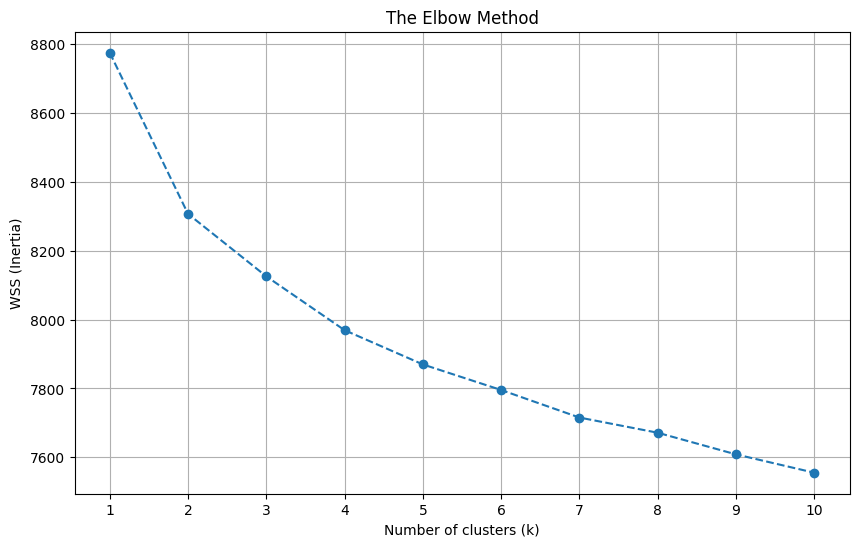

In [15]:
print("Calculating optimal 'k' for PCA-reduced data...")
find_optimal_k_elbow(resume_pca_matrix, max_k=10)

From the WSS scores, we can't specify a single K value that is good, as it;s a continuous curve and we dont get a clear elbow.

Trying silhouette scores:

In [16]:
def find_optimal_k_silhouette(data, max_k):

    k_values = range(2, max_k + 1)
    silhouette_scores = []

    for k in k_values:
        print(f"  - Calculating for k={k}...")
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
        kmeans.fit(data)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)
        print(f"    Silhouette Score: {score:.4f}")

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, silhouette_scores, marker='o', linestyle='--')
    plt.title('Silhouette Score for Various Numbers of Clusters (k)')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()


  - Calculating for k=2...
    Silhouette Score: 0.0512
  - Calculating for k=3...
    Silhouette Score: 0.0580
  - Calculating for k=4...
    Silhouette Score: 0.0467
  - Calculating for k=5...
    Silhouette Score: 0.0473
  - Calculating for k=6...
    Silhouette Score: 0.0493
  - Calculating for k=7...
    Silhouette Score: 0.0485
  - Calculating for k=8...
    Silhouette Score: 0.0485
  - Calculating for k=9...
    Silhouette Score: 0.0516
  - Calculating for k=10...
    Silhouette Score: 0.0492


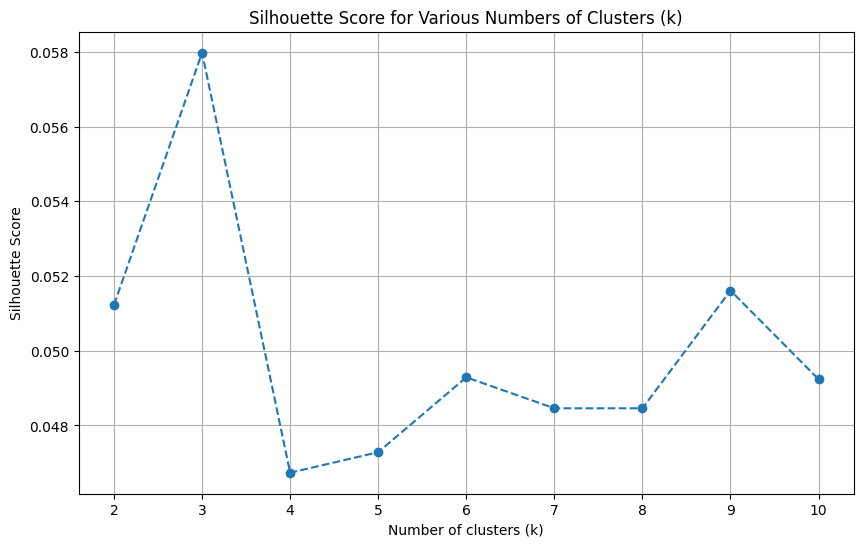

In [17]:
find_optimal_k_silhouette(resume_pca_matrix, max_k=10)

In [18]:
k_optimal = 5
kmeans = KMeans(n_clusters=k_optimal, init='k-means++', n_init=10, random_state=42)
kmeans.fit(resume_tfidf)

# Assign cluster labels back to the dataframe
df['Resume_Cluster_KMeans'] = kmeans.labels_
print(f"Assigned resumes to {k_optimal} clusters.")
print("\nCluster distribution:")
print(df['Resume_Cluster_KMeans'].value_counts())

Assigned resumes to 5 clusters.

Cluster distribution:
Resume_Cluster_KMeans
1    2894
2    2212
0    2016
3    1212
4    1210
Name: count, dtype: int64


In [19]:
def plot_cluster_word_clouds(kmeans_model, tfidf_vectorizer, n_clusters):
    print("\nTop terms per cluster:")
    order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]
    terms = tfidf_vectorizer.get_feature_names_out()
    
    for i in range(n_clusters):
        top_terms_list = [terms[ind] for ind in order_centroids[i, :20]]
        top_terms_str = " ".join(top_terms_list)
        
        print(f"Cluster {i}: {', '.join(top_terms_list[:10])}\n")
        
        wordcloud = WordCloud(width=600, height=300, background_color='white').generate(top_terms_str)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for Cluster {i}")
        plt.show()

In [20]:
def plot_and_save_cluster_word_clouds(kmeans_model, tfidf_vectorizer, n_clusters):

    print(f"\n===== Analysis for k={n_clusters} =====")
    
    # Define the base directory for saving images
    base_save_dir = f'../docs/KMeans/K{n_clusters}'
    # Create the directory if it doesn't exist
    os.makedirs(base_save_dir, exist_ok=True)
    
    # Get the top terms for each cluster from the model's centroids
    order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]
    terms = tfidf_vectorizer.get_feature_names_out()
    
    for i in range(n_clusters):
        top_terms_list = [terms[ind] for ind in order_centroids[i, :20]]
        top_terms_str = " ".join(top_terms_list)
        
        print(f"\nCluster {i}: {', '.join(top_terms_list[:10])}")
        
        wordcloud = WordCloud(width=600, height=300, background_color='white').generate(top_terms_str)
        
        fig = plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for Cluster {i} (k={n_clusters})")
        
        # Define the full path to save the image
        save_path = os.path.join(base_save_dir, f'cluster_{i}.png')
        # Save the figure before showing it
        plt.savefig(save_path, bbox_inches='tight')
        print(f"  -> Saved word cloud to: {save_path}")
        
        plt.show() # Display the plot in the notebook
        plt.close(fig) # Close the figure to free up memory


Top terms per cluster:
Cluster 0: learning, machine, python, software, intern, bachelors, stem, deep, developer, data



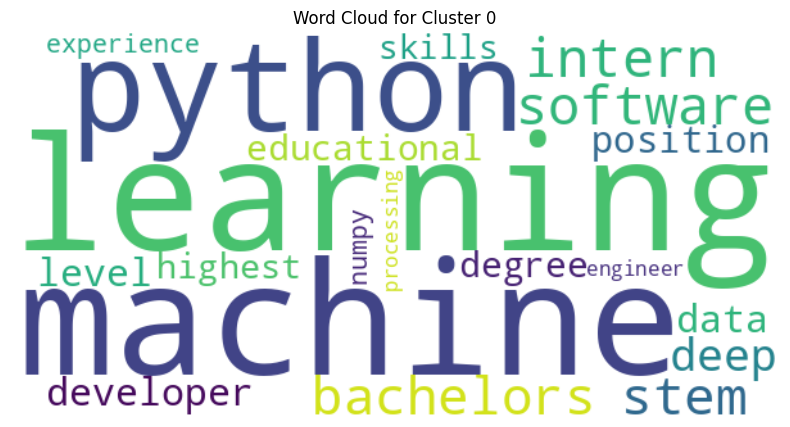

Cluster 1: engineering, technician, engineer, management, process, systems, microsoft, project, skills, design



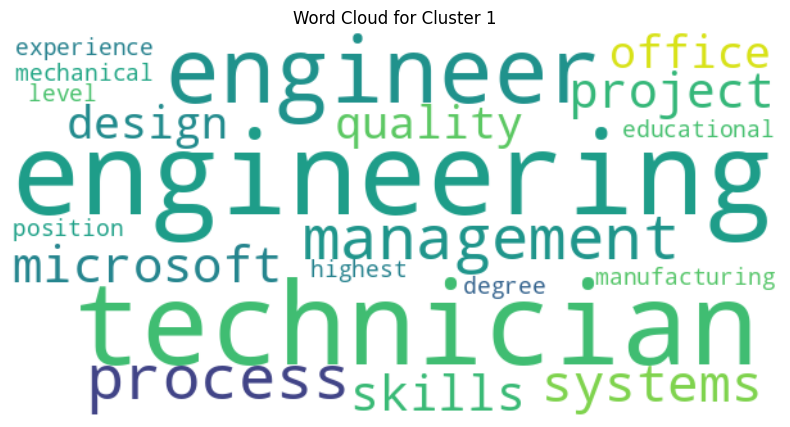

Cluster 2: data, learning, analysis, analytics, machine, python, analyst, bachelors, modeling, mining



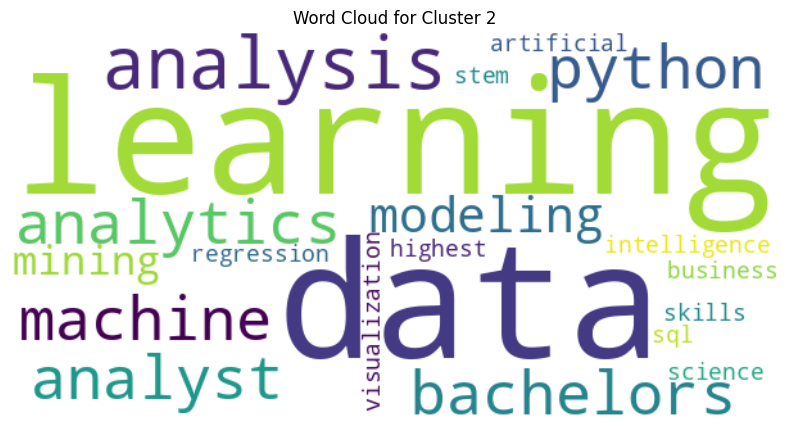

Cluster 3: manager, sales, business, management, development, marketing, project, customer, director, training



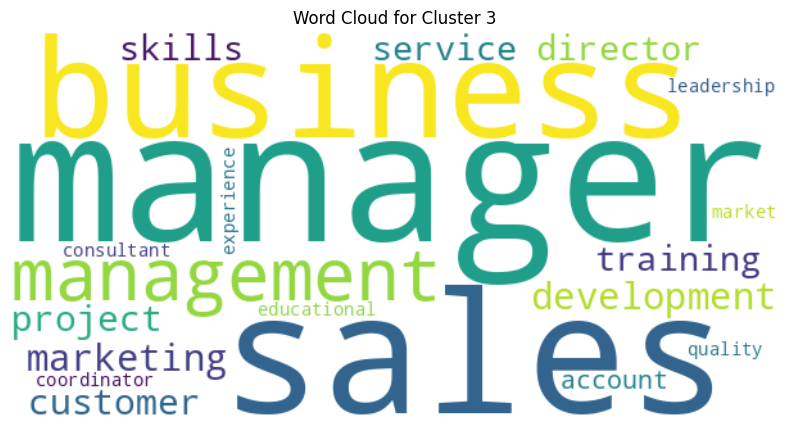

Cluster 4: accountant, financial, accounting, accounts, tax, ledger, microsoft, general, quickbooks, excel



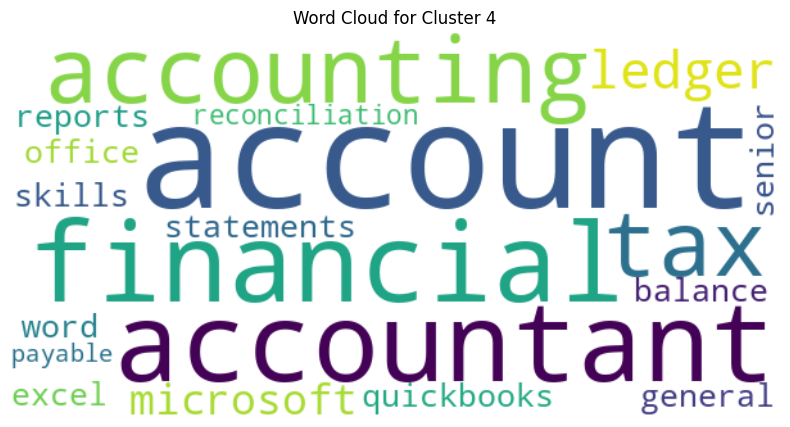

In [21]:
plot_cluster_word_clouds(kmeans, tfidf, k_optimal)

In [22]:
# for k in range(2, ):
#     kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
#     kmeans.fit(resume_tfidf)
#     plot_and_save_cluster_word_clouds(kmeans, tfidf, k)

The 7 clusters seem meaningful:

1. Cluster mostly has software, developer, python, java, html, css, etc. This cluster seems to have software development related resumes.
2. This cluster has data, learning, analytics, analyst, business, intelligence, regression, etc. This cluster seems to be having business analyst related resumes.
3. Learning, machine, deep, processing, python, numpy, keras, natural, language, etc. This cluster seems to have Machine Learning and deep learning related resumes, as we see advanced libraries like keras and advanced topics like natural language processing.
4. This cluster has mostly financial terms like account, financial, accounting, tax, microsoft, ledger, etc. This cluster includes resumes related to accounting.
5. This cluster has terms related to electrical engineering and troubleshooting like technician, engineering, test, troubleshooting, equipment, electrical, etc. This cluster has most probably captured resumes related to electrical eng. jobs.
6. This cluster also has many eng related terms, but it also has terms like management, design, project, quality, research, etc. This cluster seems to have captured resumes related to advanced project management jobs.
7. This cluster is all about business and sales related resumes. It includes terms like sales, marketing, manager, project, customer, etc. These resumes are for jobs related to sales, marketing and in business domain in general.

### Trying HAC:

Running HAC on a sample of 500 data points.


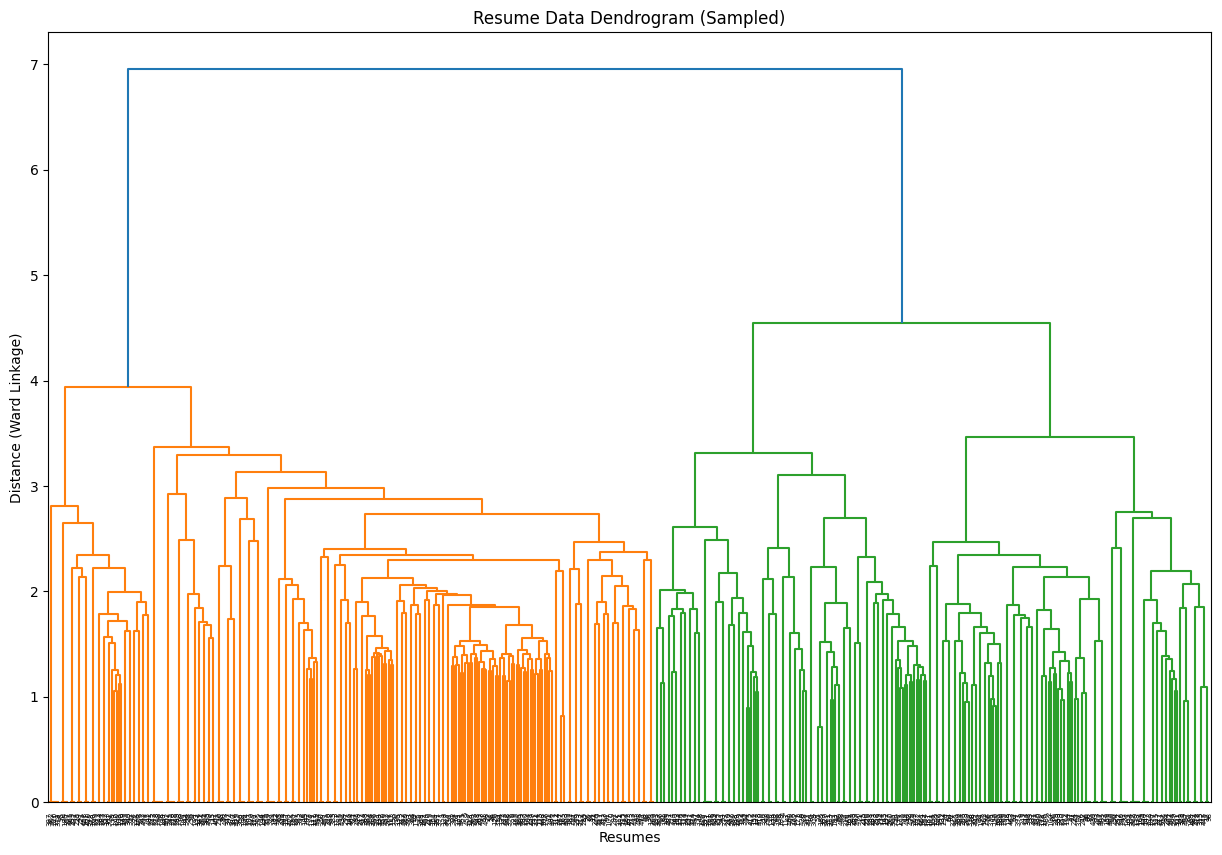

In [23]:
sample_size = 500
df_sample = df.sample(n=sample_size, random_state=42)
pca_sample = resume_pca_matrix[df_sample.index]

print(f"Running HAC on a sample of {sample_size} data points.")
plt.figure(figsize=(15, 10))
plt.title("Resume Data Dendrogram (Sampled)")
plt.xlabel("Resumes")
plt.ylabel("Distance (Ward Linkage)")

dend = shc.dendrogram(shc.linkage(pca_sample, method='ward'))
plt.show()

From the dendrogram, we see some great insights about the heirarchy within the data. 

At the upper most level, we get 2 clusters - these are mostly divided into tech and non tech.<br>
Then on a level below that, we get 4 clusters where the 1st cluster is very small and the 2nd cluster is very big (the biggest in the entire dataset, which seems to be related to ML).

However, I think we get more details and nicely separated clusters from K-Means with K=7.

In [24]:
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=42)
kmeans.fit(resume_tfidf)
    
# Add the final cluster labels to the dataframe
df['Resume_Cluster_KMeans'] = kmeans.labels_
print(f"Successfully assigned resumes to 7 clusters.")
print("\nFinal Cluster Distribution:")
print(df['Resume_Cluster_KMeans'].value_counts().sort_index())

Successfully assigned resumes to 7 clusters.

Final Cluster Distribution:
Resume_Cluster_KMeans
0    2016
1    2894
2    2212
3    1212
4    1210
Name: count, dtype: int64


In [25]:
pd.set_option('display.max_columns', None)
df.head()

,address,career_objective,skills,educational_institution_name,degree_names,passing_years,educational_results,result_types,major_field_of_studies,professional_company_names,company_urls,start_dates,end_dates,related_skils_in_job,positions,locations,responsibilities,extra_curricular_activity_types,extra_curricular_organization_names,extra_curricular_organization_links,role_positions,languages,proficiency_levels,certification_providers,certification_skills,online_links,issue_dates,expiry_dates,job_position_name,educationaL_requirements,experiencere_requirement,age_requirement,responsibilities.1,skills_required,matched_score,experience_years_required,Skill_Overlap_Count,Skill_Jaccard_Score,Resume_Years_Exp,Experience_Mismatch,highest_education_level,degree_type,resume_text,Resume_Cluster_KMeans
0,NaN,Big data analytics working and database wareho...,"['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapr...",['The Amity School of Engineering & Technology...,['B.Tech'],['2019'],['N/A'],[None],['Electronics'],['Coca-COla'],[None],['Nov 2019'],['Till Date'],[['Big Data']],['Big Data Analyst'],['N/A'],Technical Support\nTroubleshooting\nCollaborat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Senior Software Engineer,B.Sc in Computer Science & Engineering from a ...,At least 1 year,NaN,Technical Support\nTroubleshooting\nCollaborat...,NaN,0.850000,1,0.0,0.0,6,5,Bachelors,STEM,"skills ['Big Data', 'Hadoop', 'Hive', 'Python'...",2
1,NaN,Fresher looking to join as a data analyst and ...,"['Data Analysis', 'Data Analytics', 'Business ...","['Delhi University - Hansraj College', 'Delhi ...","['B.Sc (Maths)', 'M.Sc (Science) (Statistics)']","['2015', '2018']","['N/A', 'N/A']","['N/A', 'N/A']","['Mathematics', 'Statistics']",['BIB Consultancy'],['N/A'],['Sep 2019'],['Till Date'],"[['Data Analysis', 'Business Analysis', 'Machi...",['Business Analyst'],['N/A'],Machine Learning Leadership\nCross-Functional ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Machine Learning (ML) Engineer,M.Sc in Computer Science & Engineering or in a...,At least 5 year(s),NaN,Machine Learning Leadership\nCross-Functional ...,NaN,0.750000,5,0.0,0.0,6,1,Masters,STEM,"skills ['Data Analysis', 'Data Analytics', 'Bu...",2
2,NaN,NaN,"['Software Development', 'Machine Learning', '...","['Birla Institute of Technology (BIT), Ranchi']",['B.Tech'],['2018'],['N/A'],['N/A'],['Electronics/Telecommunication'],['Axis Bank Limited'],['N/A'],['June 2018'],['Till Date'],"[['Unified Payment Interface', 'Risk Predictio...",['Software Developer (Machine Learning Enginee...,['N/A'],"Trade Marketing Executive\nBrand Visibility, S...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Executive/ Senior Executive- Trade Marketing, ...",Master of Business Administration (MBA),At least 3 years,NaN,"Trade Marketing Executive\nBrand Visibility, S...",Brand Promotion\nCampaign Management\nField Su...,0.416667,3,0.0,0.0,7,4,Bachelors,STEM,"skills ['Software Development', 'Machine Learn...",0
3,NaN,To obtain a position in a fast-paced business ...,"['accounts payables', 'accounts receivables', ...","['Martinez Adult Education, Business Training ...",['Computer Applications Specialist Certificate...,['2008'],[None],[None],['Computer Applications'],"['Company Name ï¼ City , State', 'Company Name...","[None, None, None, None, None, None]","['January 2011', 'January 2008', 'January 2006...","['November 2015', 'January 2010', 'January 200...","[['accounts receivables', 'banking', 'G/L Acco...","['Accountant', 'Accounts Receivable Clerk', 'M...","['City, State', 'City, State', 'City, State', ...",Apparel Sourcing\nQuality Garment Sourcing\nRe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Business Development Executive,Bachelor/Honors,1 to 3 years,Age 22 to 30 years,Apparel Sourcing\nQuality Garment Sourcing\nRe...,Fast typing skill\nIELTSInternet browsing & on...,0.760000,1,0.0,0.0,13,12,Other,STEM,"skills ['accounts payables', 'accounts receiva...",4
4,NaN,Professional accountant with an outstanding wo...,"['Anal

### I'm also adding Cosine Similariy in the dataset:

In [26]:
df.columns

Index(['address', 'career_objective', 'skills', 'educational_institution_name',
       'degree_names', 'passing_years', 'educational_results', 'result_types',
       'major_field_of_studies', 'professional_company_names', 'company_urls',
       'start_dates', 'end_dates', 'related_skils_in_job', 'positions',
       'locations', 'responsibilities', 'extra_curricular_activity_types',
       'extra_curricular_organization_names',
       'extra_curricular_organization_links', 'role_positions', 'languages',
       'proficiency_levels', 'certification_providers', 'certification_skills',
       'online_links', 'issue_dates', 'expiry_dates', 'job_position_name',
       'educationaL_requirements', 'experiencere_requirement',
       'age_requirement', 'responsibilities.1', 'skills_required',
       'matched_score', 'experience_years_required', 'Skill_Overlap_Count',
       'Skill_Jaccard_Score', 'Resume_Years_Exp', 'Experience_Mismatch',
       'highest_education_level', 'degree_type', 'resume_t

In [27]:
df['languages'].value_counts()

languages
['English', 'Spanish']                         168
['Spanish']                                     84
['English', 'French']                           28
['Portuguese']                                  28
['English', 'Marathi', 'Hindi', 'Gujarati']     28
['English', 'Urdu', 'German']                   28
['English', 'French', 'Spanish']                28
['English', 'Arabic', 'Swedish']                28
['Arabic', 'English']                           28
['English', 'Chinese Mandarin']                 28
['English', 'Mandarin', 'Cantonese']            28
['English', 'Swahili', 'Kalenjin']              28
['English', 'French', 'Italian', 'Greek']       28
['Spanish', 'English', 'Portuguese']            28
['Japanese', 'English']                         28
['Polish']                                      28
['English', 'Hebrew']                           28
['English', 'Hindi', 'Malayalam']               28
Name: count, dtype: int64

Cols to use for Cosine Sim:<br>
Resume: career_objective, skills, major_field_of_studies, positions, responsibilities.<br>
Job: job_position_name, educationaL_requirements, responsibilities

In [28]:

resume_text_cols = ['career_objective', 'skills', 'major_field_of_studies', 'positions', 'highest_education_level', 'degree_type']

job_text_cols = ['job_position_name', 'educationaL_requirements', 'skills_required', 'responsibilities.1']

In [29]:
df['resume_text_for_sim'] = df[resume_text_cols].fillna('').astype(str).agg(' '.join, axis=1)
df['job_text_for_sim'] = df[job_text_cols].fillna('').astype(str).agg(' '.join, axis=1)

In [30]:
# We use a new vectorizer to learn the vocabulary of both resumes and jobs
sim_vectorizer = TfidfVectorizer(stop_words='english', min_df=2)

# Fit on the combined corpus of all resume and job text
all_text = pd.concat([df['resume_text_for_sim'], df['job_text_for_sim']], axis=0)
sim_vectorizer.fit(all_text)

# Transform resume and job texts separately using the learned vocabulary
resume_vecs = sim_vectorizer.transform(df['resume_text_for_sim'])
job_vecs = sim_vectorizer.transform(df['job_text_for_sim'])

# Calculate cosine similarity row-by-row and add it as a feature
df['Cosine_Similarity'] = 1 - pairwise_distances(resume_vecs, job_vecs, metric='cosine').diagonal()
    
print("Added the final 'Cosine_Similarity' feature.")
display(df[['Cosine_Similarity', 'Resume_Cluster_KMeans']].head())


Added the final 'Cosine_Similarity' feature.


,Cosine_Similarity,Resume_Cluster_KMeans
0,0.006683,2
1,0.094794,2
2,0.000000,0
3,0.022270,4
4,0.008438,4


In [33]:
import sys
!{sys.executable} -m pip install -U sentence-transformers

  Using cached sentence_transformers-4.1.0-py3-none-any.whl.metadata (13 kB)
  Using cached transformers-4.52.4-py3-none-any.whl.metadata (38 kB)
  Using cached huggingface_hub-0.32.5-py3-none-any.whl.metadata (14 kB)
  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached tokenizers-0.21.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl.metadata (3.9 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached sentence_transformers-4.1.0-py3-none-any.whl (345 kB)
Using cached huggingface_hub-0.32.5-py3-none-any.whl (512 kB)
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
    --------------------------------------- 2.9/216.1 MB 27.9 MB/s eta 0:00:08
   - -------------------------------------- 9.2/216.1 MB 31.7 MB/s eta 0:00:07
   --- --------------


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\HP\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [35]:
df_raw = df.copy()


--- Calculating Similarity with Sentence-BERT Embeddings ---
Generating resume embeddings... (This may take a moment)


Batches:   0%|          | 0/299 [00:00<?, ?it/s]

Generating job embeddings...


Batches:   0%|          | 0/299 [00:00<?, ?it/s]

Created 'Embedding_Cosine_Similarity' feature.


C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


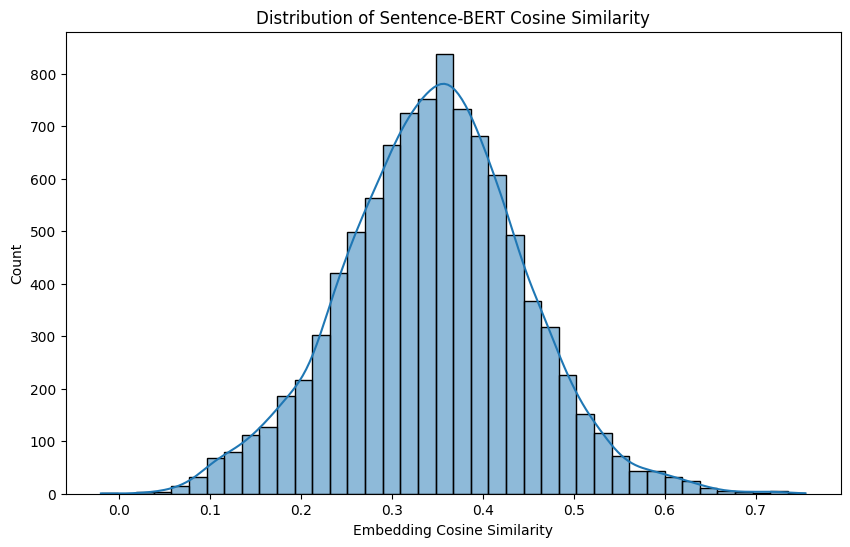

In [36]:

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
    
print("\n--- Calculating Similarity with Sentence-BERT Embeddings ---")
    
    # 1. Load a pre-trained model
    # 'all-MiniLM-L6-v2' is a great general-purpose model: fast and effective.
model = SentenceTransformer('all-MiniLM-L6-v2')

    # 2. Create the rich text documents for resumes and jobs
resume_text_cols = ['career_objective', 'skills', 'major_field_of_studies', 'positions', 'highest_education_level', 'degree_type']
job_text_cols = ['job_position_name', 'educationaL_requirements', 'skills_required', 'responsibilities.1']

df_raw['resume_text_for_embedding'] = df_raw[resume_text_cols].fillna('').astype(str).agg(' '.join, axis=1)
df_raw['job_text_for_embedding'] = df_raw[job_text_cols].fillna('').astype(str).agg(' '.join, axis=1)
    
    # 3. Generate embeddings for all documents
    # This can take a few minutes as it uses the deep learning model
print("Generating resume embeddings... (This may take a moment)")
resume_embeddings = model.encode(df_raw['resume_text_for_embedding'].tolist(), show_progress_bar=True)
    
print("Generating job embeddings...")
job_embeddings = model.encode(df_raw['job_text_for_embedding'].tolist(), show_progress_bar=True)

    # 4. Calculate cosine similarity row-by-row
    # We loop to calculate similarity for each (resume_i, job_i) pair
similarities = [cosine_similarity([resume_embeddings[i]], [job_embeddings[i]])[0][0] for i in range(len(resume_embeddings))]

    # 5. Create the new feature
df_raw['Embedding_Cosine_Similarity'] = similarities
print("Created 'Embedding_Cosine_Similarity' feature.")

    # 6. Visualize the new distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_raw['Embedding_Cosine_Similarity'], bins=40, kde=True)
plt.title('Distribution of Sentence-BERT Cosine Similarity')
plt.xlabel('Embedding Cosine Similarity')
plt.ylabel('Count')
plt.show()


In [38]:
df_raw.head()

,address,career_objective,skills,educational_institution_name,degree_names,passing_years,educational_results,result_types,major_field_of_studies,professional_company_names,company_urls,start_dates,end_dates,related_skils_in_job,positions,locations,responsibilities,extra_curricular_activity_types,extra_curricular_organization_names,extra_curricular_organization_links,role_positions,languages,proficiency_levels,certification_providers,certification_skills,online_links,issue_dates,expiry_dates,job_position_name,educationaL_requirements,experiencere_requirement,age_requirement,responsibilities.1,skills_required,matched_score,experience_years_required,Skill_Overlap_Count,Skill_Jaccard_Score,Resume_Years_Exp,Experience_Mismatch,highest_education_level,degree_type,resume_text,Resume_Cluster_KMeans,resume_text_for_sim,job_text_for_sim,Cosine_Similarity,resume_text_for_embedding,job_text_for_embedding,Embedding_Cosine_Similarity
0,NaN,Big data analytics working and database wareho...,"['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapr...",['The Amity School of Engineering & Technology...,['B.Tech'],['2019'],['N/A'],[None],['Electronics'],['Coca-COla'],[None],['Nov 2019'],['Till Date'],[['Big Data']],['Big Data Analyst'],['N/A'],Technical Support\nTroubleshooting\nCollaborat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Senior Software Engineer,B.Sc in Computer Science & Engineering from a ...,At least 1 year,NaN,Technical Support\nTroubleshooting\nCollaborat...,NaN,0.850000,1,0.0,0.0,6,5,Bachelors,STEM,"skills ['Big Data', 'Hadoop', 'Hive', 'Python'...",2,Big data analytics working and database wareho...,Senior Software Engineer B.Sc in Computer Scie...,0.006683,Big data analytics working and database wareho...,Senior Software Engineer B.Sc in Computer Scie...,0.419060
1,NaN,Fresher looking to join as a data analyst and ...,"['Data Analysis', 'Data Analytics', 'Business ...","['Delhi University - Hansraj College', 'Delhi ...","['B.Sc (Maths)', 'M.Sc (Science) (Statistics)']","['2015', '2018']","['N/A', 'N/A']","['N/A', 'N/A']","['Mathematics', 'Statistics']",['BIB Consultancy'],['N/A'],['Sep 2019'],['Till Date'],"[['Data Analysis', 'Business Analysis', 'Machi...",['Business Analyst'],['N/A'],Machine Learning Leadership\nCross-Functional ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Machine Learning (ML) Engineer,M.Sc in Computer Science & Engineering or in a...,At least 5 year(s),NaN,Machine Learning Leadership\nCross-Functional ...,NaN,0.750000,5,0.0,0.0,6,1,Masters,STEM,"skills ['Data Analysis', 'Data Analytics', 'Bu...",2,Fresher looking to join as a data analyst and ...,Machine Learning (ML) Engineer M.Sc in Compute...,0.094794,Fresher looking to join as a data analyst and ...,Machine Learning (ML) Engineer M.Sc in Compute...,0.494434
2,NaN,NaN,"['Software Development', 'Machine Learning', '...","['Birla Institute of Technology (BIT), Ranchi']",['B.Tech'],['2018'],['N/A'],['N/A'],['Electronics/Telecommunication'],['Axis Bank Limited'],['N/A'],['June 2018'],['Till Date'],"[['Unified Payment Interface', 'Risk Predictio...",['Software Developer (Machine Learning Enginee...,['N/A'],"Trade Marketing Executive\nBrand Visibility, S...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Executive/ Senior Executive- Trade Marketing, ...",Master of Business Administration (MBA),At least 3 years,NaN,"Trade Marketing Executive\nBrand Visibility, S...",Brand Promotion\nCampaign Management\nField Su...,0.416667,3,0.0,0.0,7,4,Bachelors,STEM,"skills ['Software Development', 'Machine Learn...",0,"['Software Development', 'Machine Learning', ...","Executive/ Senior Executive- Trade Marketing, ...",0.000000,"['Software Development', 'Machine Learning', ...","Executive/ Senior Executive- Trade Marketing, ...",0.354318
3,NaN,To obtain a position in a fast-paced business ...,"['accounts payables', 'accounts receivables', ...","['Martinez Adult Education, Business Training ...",['Computer Applications Specialist Certificate...,['2008'],[None],[None],['Computer 

C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='matched_score', ylabel='Count'>

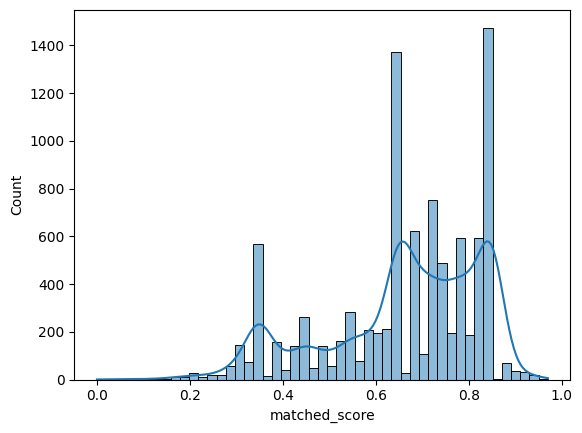

In [39]:
sns.histplot(df['matched_score'], kde=True)

C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Cosine_Similarity', ylabel='Count'>

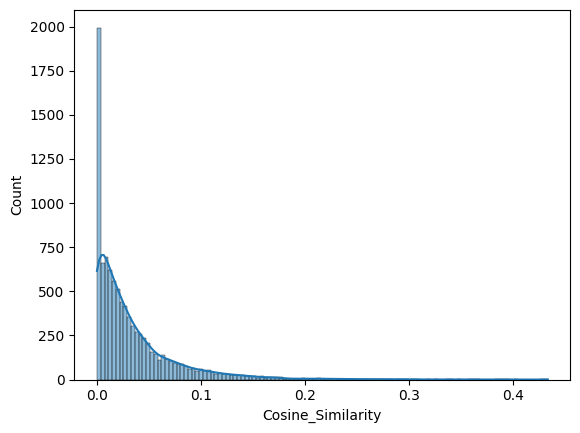

In [40]:
sns.histplot(df['Cosine_Similarity'], kde=True)

In [41]:
sum(df['responsibilities'] == df['responsibilities.1'])

9544

### Saving the data for future use:

In [42]:
output_path = '../data/processed/final_model_data.csv'
print(f"\n--- Step 8: Saving final data for modeling to {output_path} ---")
try:
    # Drop the temporary text columns before saving
    cols_to_drop = ['resume_text', 'resume_text_for_sim', 'job_text_for_sim', 'company_urls', 'start_dates', 'end_dates']
    df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

    df_raw.to_csv(output_path, index=False)
    print("File saved successfully!")
    print("This file contains all features and is ready for Phase 3.")
except Exception as e:
    print(f"An error occurred while saving the file: {e}")


--- Step 8: Saving final data for modeling to ../data/processed/final_model_data.csv ---
File saved successfully!
This file contains all features and is ready for Phase 3.
